In [2]:
# Standard libraries
import warnings
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Machine Learning libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor, XGBClassifier

# Time series analysis library
from statsmodels.tsa.arima.model import ARIMA

# Financial data library
import yfinance as yf

# Other libraries
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Settings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline


In [3]:
# Define the ticker symbol for the S&P 500
ticker = "^GSPC"

# Calculate the start and end dates
end_date = datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=5 * 365)).strftime("%Y-%m-%d")

# Get the historical data
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-24,2737.870117,2742.590088,2651.889893,2656.100098,2656.100098,4738670000
2018-10-25,2674.879883,2722.699951,2667.840088,2705.570068,2705.570068,4663930000
2018-10-26,2667.860107,2692.379883,2628.159912,2658.689941,2658.689941,4804330000
2018-10-29,2682.649902,2706.850098,2603.540039,2641.250000,2641.250000,4701260000
2018-10-30,2640.679932,2685.429932,2635.340088,2682.629883,2682.629883,5125600000


In [5]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-16,4342.370117,4383.330078,4342.370117,4373.629883,4373.629883,3409960000
2023-10-17,4345.229980,4393.569824,4337.540039,4373.200195,4373.200195,3794850000
2023-10-18,4357.350098,4364.200195,4303.839844,4314.600098,4314.600098,3686030000
2023-10-19,4321.359863,4339.540039,4269.689941,4278.000000,4278.000000,3969730000
2023-10-20,4273.850098,4276.560059,4223.029785,4224.160156,4224.160156,4004030000


In [6]:
# "Close" and "Adj Close" columns are about 90% or more alike
data.drop(columns='Adj Close', axis=1, inplace=True)

## Exploratory Data Analysis


## Feature Engineering

In [7]:
# function to extract date parts
def extract_date(df):
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.isocalendar().week
    return df

In [8]:
data = extract_date(data.reset_index('Date'))
data.head()

,Date,Open,High,Low,Close,Volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2018-10-24,2737.870117,2742.590088,2651.889893,2656.100098,4738670000,2,4,10,2018,297,24,43
1,2018-10-25,2674.879883,2722.699951,2667.840088,2705.570068,4663930000,3,4,10,2018,298,25,43
2,2018-10-26,2667.860107,2692.379883,2628.159912,2658.689941,4804330000,4,4,10,2018,299,26,43
3,2018-10-29,2682.649902,2706.850098,2603.540039,2641.250000,4701260000,0,4,10,2018,302,29,44
4,2018-10-30,2640.679932,2685.429932,2635.340088,2682.629883,5125600000,1,4,10,2018,303,30,44


In [9]:
# functions for features engineering

def calculate_z_score(data): # to reduce the spiking of the traded volume when beyond 3 standard deviation
    data['z_score'] = stats.zscore(data['Volume'])
    data = data.loc[data['z_score'].abs()<=3]
    return data

def calculate_moving_average(data):
    data['50_Day_MA'] = data['Close'].rolling(window=50).mean()
    data['200_Day_MA'] = data['Close'].rolling(window=200).mean()
    return data

def calculate_volatility(data):
    data['Daily_Return'] = (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1)
    data['Volatility'] = data['Daily_Return'].rolling(window=20).std()
    return data

def determine_market_regime(data):
    # Initialize to Sideways
    data['Market_Regime'] = 'Sideways Market'  

    # Define the conditions for Bull and Bear Markets
    bull_condition = (data['Close'] > data['50_Day_MA']) & (data['Close'] > data['200_Day_MA'])
    bear_condition = (data['Close'] < data['50_Day_MA']) & (data['Close'] < data['200_Day_MA'])

    # Set the Market_Regime based on conditions
    data.loc[bull_condition, 'Market_Regime'] = 'Bull Market'
    data.loc[bear_condition, 'Market_Regime'] = 'Bear Market'
    
    return data

def map_market_regime(data):
    # define the mapping
    market_regime_mapping = {
        'Sideways Market': 0,
        'Bull Market': 1,
        'Bear Market': 2
    }

    # Create the 'Market_Regime_Category' column based on the mapping
    data['Market_Regime_Category'] = data['Market_Regime'].map(market_regime_mapping)
    
    return data

In [10]:
# applying the functions on data (dataframe):
data = calculate_z_score(data)
data = calculate_moving_average(data)
data = calculate_volatility(data)
data = determine_market_regime(data)
data = map_market_regime(data)

In [11]:
def handle_missing_values(data):
    # Drop rows where 'Volatility' is NaN
    data.dropna(subset=['Volatility'], inplace=True)

    # Forward fill missing values in the '50 Day' and '200 Day' moving averages for the first rows
    data['50_Day_MA'].fillna(method='bfill', inplace=True)
    data['200_Day_MA'].fillna(method='bfill', inplace=True)
    
    return data

data = handle_missing_values(data)

In [12]:
data.head()

,Date,Open,High,Low,Close,Volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,z_score,50_Day_MA,200_Day_MA,Daily_Return,Volatility,Market_Regime,Market_Regime_Category
20,2018-11-21,2657.739990,2670.729980,2649.820068,2649.929932,3237400000,2,4,11,2018,325,21,47,-1.009834,2644.400396,2796.251694,0.003043,0.012558,Sideways Market,0
21,2018-11-23,2633.360107,2647.550049,2631.090088,2632.560059,1651680000,4,4,11,2018,327,23,47,-2.497977,2644.400396,2796.251694,-0.006555,0.011829,Sideways Market,0
22,2018-11-26,2649.969971,2674.350098,2649.969971,2673.449951,3523520000,0,4,11,2018,330,26,48,-0.741320,2644.400396,2796.251694,0.015532,0.011768,Sideways Market,0
23,2018-11-27,2663.750000,2682.530029,2655.889893,2682.169922,3494380000,1,4,11,2018,331,27,48,-0.768667,2644.400396,2796.251694,0.003262,0.011669,Sideways Market,0
24,2018-11-28,2691.449951,2744.000000,2684.379883,2743.790039,3984540000,2,4,11,2018,332,28,48,-0.308669,2644.400396,2796.251694,0.022974,0.012258,Sideways Market,0


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1207 entries, 20 to 1255
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    1207 non-null   datetime64[ns]
 1   Open                    1207 non-null   float64       
 2   High                    1207 non-null   float64       
 3   Low                     1207 non-null   float64       
 4   Close                   1207 non-null   float64       
 5   Volume                  1207 non-null   int64         
 6   dayofweek               1207 non-null   int32         
 7   quarter                 1207 non-null   int32         
 8   month                   1207 non-null   int32         
 9   year                    1207 non-null   int32         
 10  dayofyear               1207 non-null   int32         
 11  dayofmonth              1207 non-null   int32         
 12  weekofyear              1207 non-null   UInt32      

In [14]:
data.shape

(1207, 20)

In [15]:
data.isna().sum()

Date                      0
Open                      0
High                      0
Low                       0
Close                     0
Volume                    0
dayofweek                 0
quarter                   0
month                     0
year                      0
dayofyear                 0
dayofmonth                0
weekofyear                0
z_score                   0
50_Day_MA                 0
200_Day_MA                0
Daily_Return              0
Volatility                0
Market_Regime             0
Market_Regime_Category    0
dtype: int64

In [16]:
data.tail()

,Date,Open,High,Low,Close,Volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,z_score,50_Day_MA,200_Day_MA,Daily_Return,Volatility,Market_Regime,Market_Regime_Category
1251,2023-10-16,4342.370117,4383.330078,4342.370117,4373.629883,3409960000,0,4,10,2023,289,16,42,-0.847892,4405.030195,4220.850802,0.005522,0.007880,Sideways Market,0
1252,2023-10-17,4345.229980,4393.569824,4337.540039,4373.200195,3794850000,1,4,10,2023,290,17,42,-0.486686,4402.933604,4223.570553,-0.000098,0.007874,Sideways Market,0
1253,2023-10-18,4357.350098,4364.200195,4303.839844,4314.600098,3686030000,2,4,10,2023,291,18,42,-0.588810,4398.856807,4226.227454,-0.013400,0.008356,Sideways Market,0
1254,2023-10-19,4321.359863,4339.540039,4269.689941,4278.000000,3969730000,3,4,10,2023,292,19,42,-0.322567,4394.429209,4228.371053,-0.008483,0.008313,Sideways Market,0
1255,2023-10-20,4273.850098,4276.560059,4223.029785,4224.160156,4004030000,4,4,10,2023,293,20,42,-0.290378,4389.558213,4230.294354,-0.012585,0.007988,Bear Market,2


In [17]:
data.set_index('Date', inplace=True) # making data the index train and test easy split

In [18]:
data.describe()

,Open,High,Low,Close,Volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,z_score,50_Day_MA,200_Day_MA,Daily_Return,Volatility,Market_Regime_Category
count,1207.000000,1207.000000,1207.000000,1207.000000,1.207000e+03,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.0,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000,1207.000000
mean,3714.954596,3737.194275,3691.277620,3715.632436,4.224503e+09,2.009114,2.506214,6.514499,2020.862469,182.799503,15.714167,26.46976,-0.083472,3681.146273,3593.484224,0.000483,0.011195,0.835957
std,633.751302,636.703177,630.739372,633.568638,8.803209e+08,1.390831,1.103178,3.414132,1.437236,104.388631,8.812888,14.924538,0.826151,633.174049,609.203847,0.013594,0.007943,0.678697
min,2290.709961,2300.729980,2191.860107,2237.399902,1.296530e+09,0.000000,1.000000,1.000000,2018.000000,2.000000,1.000000,1.0,-2.831273,2615.226001,2796.251694,-0.183842,0.003139,0.000000
25%,3088.344971,3106.360107,3075.345093,3093.140015,3.655625e+09,1.000000,2.000000,4.000000,2020.000000,94.000000,8.000000,14.0,-0.617344,3018.553391,3020.781843,-0.005250,0.006865,0.000000
50%,3858.850098,3894.560059,3827.909912,3859.110107,4.045480e+09,2.000000,3.000000,7.000000,2021.000000,184.000000,16.000000,27.0,-0.251479,3869.261216,3707.607362,0.000837,0.009234,1.000000
75%,4258.140137,4287.225098,4222.064941,4263.100098,4.642940e+09,3.000000,3.000000,9.000000,2022.000000,271.000000,23.000000,39.0,0.309217,4232.307993,4140.186729,0.007131,0.013481,1.000000
max,4804.509766,4818.620117,4780.040039,4796.560059,7.493660e+09,4.000000,4.000000,12.000000,2023.000000,366.000000,31.000000,53.0,2.984520,4681.810205,4494.995137,0.135903,0.063673,2.000000


In [19]:
# make a copy for a later use
df = data.copy()

In [20]:
df.shape

(1207, 19)

In [21]:
# creating "Target" feature from data['Close'] column
df['target'] = df['Close'].shift(-30)

# Drop the last row as the target will be NaN
df = df[:-30]

In [22]:
df.shape

(1177, 20)

In [23]:
# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'dayofweek', 'quarter', 'month', 'year', 
            'dayofyear', 'dayofmonth', 'weekofyear', '50_Day_MA', '200_Day_MA', 
            'Daily_Return', 'Volatility', 'Market_Regime_Category']
target = 'target'

In [24]:
# Define the parameter grid for RandomizedSearchCV
param_random = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 10],
    "gamma": [0.1, 0.2, 0.4],
    "min_child_weight": [1, 3, 7],
    "n_jobs": [-1],
    "subsample": [0.1, 0.2, 0.3],
    "learning_rate": [0.01, 0.1, 0.2]
}


# Initialize the model and RandomizedSearchCV
model = XGBRegressor(random_state=42)
rsearch = RandomizedSearchCV(model, param_random, cv=3, scoring="neg_mean_squared_error")

# Number of days for test set
test_days = 30

# Create rolling window train/test splits
for i in range(test_days, len(df), test_days):
    train = df.iloc[:i]
    test = df.iloc[i:i+test_days]

    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    # Fit the model to your training data
    rsearch.fit(X_train, y_train)

    # Make predictions on your test data
    y_pred = rsearch.predict(X_test)

    # Calculate error metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

MSE: 23804.7605, RMSE: 154.2879, MAE: 143.8466
MSE: 8739.6274, RMSE: 93.4860, MAE: 88.7407
MSE: 5936.8591, RMSE: 77.0510, MAE: 64.7245
MSE: 19037.8675, RMSE: 137.9778, MAE: 129.5448
MSE: 17743.0975, RMSE: 133.2032, MAE: 123.2241
MSE: 10704.2744, RMSE: 103.4615, MAE: 93.3296
MSE: 61014.6783, RMSE: 247.0115, MAE: 239.5970
MSE: 14276.9459, RMSE: 119.4862, MAE: 113.5806
MSE: 130973.9725, RMSE: 361.9033, MAE: 265.6477
MSE: 36340.2124, RMSE: 190.6311, MAE: 169.1344
MSE: 14930.2767, RMSE: 122.1895, MAE: 103.7400
MSE: 42626.0672, RMSE: 206.4608, MAE: 199.1787
MSE: 63461.4438, RMSE: 251.9155, MAE: 183.9734
MSE: 112202.3296, RMSE: 334.9662, MAE: 312.1802
MSE: 101915.6654, RMSE: 319.2423, MAE: 315.2551
MSE: 187207.7284, RMSE: 432.6751, MAE: 427.6462
MSE: 275952.1137, RMSE: 525.3114, MAE: 522.5111
MSE: 28531.4006, RMSE: 168.9124, MAE: 160.1774
MSE: 9601.9434, RMSE: 97.9895, MAE: 81.7821
MSE: 25780.1993, RMSE: 160.5621, MAE: 152.7936
MSE: 12206.1404, RMSE: 110.4814, MAE: 96.1978
MSE: 15587.6289, RM

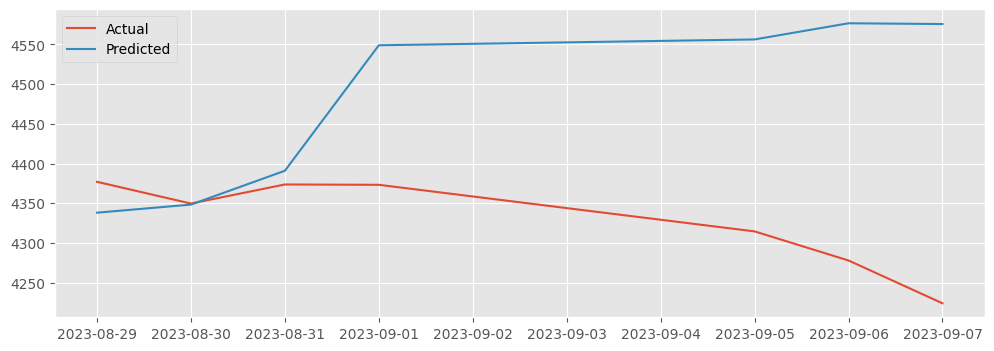

In [25]:
# Visualizing to compare between y_test and y_pred
fig = plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.legend()
plt.show()

In [26]:
# Define entire dataset's features and target
X = df[features]
y = df[target]

In [27]:
# Use the entire dataset to fit a final xgboost model
best_model = rsearch.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
best_model.fit(df[features], df[target])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [30]:
# Generate future dates
us_holidays = CustomBusinessDay(calendar=USFederalHolidayCalendar()) # to take care of US holidays and weekend
future_dates = pd.date_range(start=data.index[-1], periods=29+1, freq=us_holidays) # +1 to include last date in data
future_dates


DatetimeIndex(['2023-10-20', '2023-10-23', '2023-10-24', '2023-10-25',
               '2023-10-26', '2023-10-27', '2023-10-30', '2023-10-31',
               '2023-11-01', '2023-11-02', '2023-11-03', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-13',
               '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
               '2023-11-20', '2023-11-21', '2023-11-22', '2023-11-24',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-04'],
              dtype='datetime64[ns]', freq='C')

In [31]:
# Fit the model for 'Open' prices
model_open = ARIMA(data['Open'], order=(5,1,0))
model_fit_open = model_open.fit()
future_open = model_fit_open.forecast(steps=30)

# Fit the model for 'High' prices
model_high = ARIMA(data['High'], order=(5,1,0))
model_fit_high = model_high.fit()
future_high = model_fit_high.forecast(steps=30)

# Fit the model for 'Low' prices
model_low = ARIMA(data['Low'], order=(5,1,0))
model_fit_low = model_low.fit()
future_low = model_fit_low.forecast(steps=30)

# Fit the model for 'Close' prices
model_close = ARIMA(data['Close'], order=(5,1,0))
model_fit_close = model_close.fit()
future_close = model_fit_close.forecast(steps=30)

# Fit the model for 'Volume'
model_volume = ARIMA(data['Volume'], order=(5,1,0))
model_fit_volume = model_volume.fit()
future_volume = model_fit_volume.forecast(steps=30)

In [32]:
# Create a new DataFrame for future data
future_data = pd.DataFrame(index=future_dates)

# Reset the index of your dataframes
future_open = future_open.reset_index(drop=True)
future_high = future_high.reset_index(drop=True)
future_low = future_low.reset_index(drop=True)
future_close = future_close.reset_index(drop=True)
future_volume = future_volume.reset_index(drop=True)

# Set the new index to be the same as future_data
future_open.index = future_data.index
future_high.index = future_data.index
future_low.index = future_data.index
future_close.index = future_data.index
future_volume.index = future_data.index

# Now you can assign these dataframes to future_data
future_data['Open'] = future_open
future_data['High'] = future_high
future_data['Low'] = future_low
future_data['Close'] = future_close
future_data['Volume'] = future_volume


future_data['dayofweek'] = future_data.index.dayofweek
future_data['quarter'] = future_data.index.quarter
future_data['month'] = future_data.index.month
future_data['year'] = future_data.index.year
future_data['dayofyear'] = future_data.index.dayofyear
future_data['dayofmonth'] = future_data.index.day
future_data['weekofyear'] = future_data.index.isocalendar().week


# Fit ARIMA models for '50_Day_MA', '200_Day_MA', 'Daily_Return', and 'Volatility'
# Without using ARIMA models for all of these columns, Nan values will be part of the rows, which will affect our prediction
model_50_day_ma = ARIMA(data['50_Day_MA'].dropna(), order=(5,1,0))
model_fit_50_day_ma = model_50_day_ma.fit()
future_50_day_ma = model_fit_50_day_ma.forecast(steps=30)

model_200_day_ma = ARIMA(data['200_Day_MA'].dropna(), order=(5,1,0))
model_fit_200_day_ma = model_200_day_ma.fit()
future_200_day_ma = model_fit_200_day_ma.forecast(steps=30)

model_daily_return = ARIMA(data['Daily_Return'].dropna(), order=(5,1,0))
model_fit_daily_return = model_daily_return.fit()
future_daily_return = model_fit_daily_return.forecast(steps=30)

model_volatility = ARIMA(data['Volatility'].dropna(), order=(5,1,0))
model_fit_volatility = model_volatility.fit()
future_volatility = model_fit_volatility.forecast(steps=30)

# Reset the index of your dataframes
future_50_day_ma.index = future_data.index
future_200_day_ma.index = future_data.index
future_daily_return.index = future_data.index
future_volatility.index = future_data.index

# Assign these dataframes to future_data
future_data['50_Day_MA'] = future_50_day_ma[0]
future_data['200_Day_MA'] = future_200_day_ma[0]
future_data['Daily_Return'] = future_daily_return[0]
future_data['Volatility'] = future_volatility[0]



# Initialize Market_Regime to Sideways Market
future_data['Market_Regime'] = 'Sideways Market'

# Define the conditions for Bull and Bear Markets
bull_condition = (future_data['Close'] > future_data['50_Day_MA']) & (future_data['Close'] > future_data['200_Day_MA'])
bear_condition = (future_data['Close'] < future_data['50_Day_MA']) & (future_data['Close'] < future_data['200_Day_MA'])

# Set the Market_Regime based on conditions
future_data.loc[bull_condition, 'Market_Regime'] = 'Bull Market'
future_data.loc[bear_condition, 'Market_Regime'] = 'Bear Market'

# define the mapping
market_regime_mapping = {
    'Sideways Market': 0,
    'Bull Market': 1,
    'Bear Market': 2
}

# Create the 'Market_Regime_Category' column based on the mapping
future_data['Market_Regime_Category'] = future_data['Market_Regime'].map(market_regime_mapping)

In [33]:
# future data - next 30 days
future_data.head(3)

,Open,High,Low,Close,Volume,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,50_Day_MA,200_Day_MA,Daily_Return,Volatility,Market_Regime,Market_Regime_Category
2023-10-20,4272.681257,4275.110123,4221.927774,4230.640931,3.892334e+09,4,4,10,2023,293,20,42,4384.963709,4232.237755,-0.004511,0.007864,Bear Market,2
2023-10-23,4276.703589,4277.796048,4225.523725,4233.838951,3.851324e+09,0,4,10,2023,296,23,43,4384.963709,4232.237755,-0.004511,0.007864,Sideways Market,0
2023-10-24,4280.622680,4281.076040,4229.965925,4236.049622,3.865080e+09,1,4,10,2023,297,24,43,4384.963709,4232.237755,-0.004511,0.007864,Sideways Market,0


In [34]:
next_30_days = future_data[features]

In [35]:
best_model.predict(next_30_days)

array([4417.2686, 4421.342 , 4421.3486, 4449.629 , 4453.494 , 4472.1353,
       4421.4014, 4421.702 , 4484.875 , 4487.9355, 4466.239 , 4435.1626,
       4422.778 , 4440.45  , 4431.221 , 4432.7373, 4436.2363, 4438.42  ,
       4429.4404, 4402.134 , 4418.542 , 4407.646 , 4412.133 , 4415.2847,
       4468.03  , 4452.3467, 4429.551 , 4371.243 , 4441.959 , 4397.873 ],
      dtype=float32)

In [37]:
future_data.index

DatetimeIndex(['2023-10-20', '2023-10-23', '2023-10-24', '2023-10-25',
               '2023-10-26', '2023-10-27', '2023-10-30', '2023-10-31',
               '2023-11-01', '2023-11-02', '2023-11-03', '2023-11-06',
               '2023-11-07', '2023-11-08', '2023-11-09', '2023-11-13',
               '2023-11-14', '2023-11-15', '2023-11-16', '2023-11-17',
               '2023-11-20', '2023-11-21', '2023-11-22', '2023-11-24',
               '2023-11-27', '2023-11-28', '2023-11-29', '2023-11-30',
               '2023-12-01', '2023-12-04'],
              dtype='datetime64[ns]', freq='C')

<Axes: >

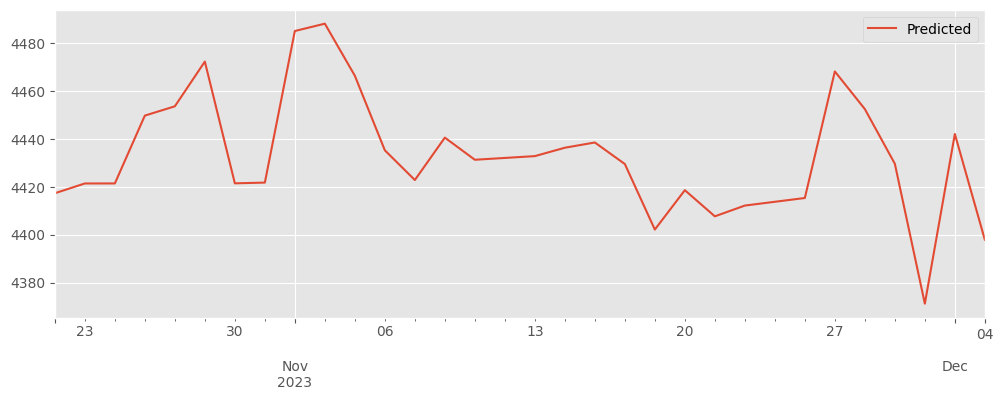

In [38]:
result = pd.DataFrame({'Predicted': best_model.predict(next_30_days)}, future_data.index)
result.plot(figsize=(12,4))